<h3 style="text-align:center">
    In the name of God
</h3>
<p style="text-align:left">
    Machine Learning Course 1400, Dr. Sajedi
    <br>HW2
    <br>Alireza Kazemipour
    <br>610300171
</p>

### Installing the package for Neural Networks computations
_nn-without-frameworks_ is the package developed by myself to implement different neural networks' configuration, architectures and etc __without using famous and popular scientific packages like PyTorch or Tensorflow__. It is solely based on NumyPy.  

For compatibility matters, the _0.0.14_ version as been fixed here to be used as it is the latest stable version yet.

For more information you may visit this [repository](https://github.com/alirezakazemipour/NN-Without-Frameworks).

In [3]:
!pip install nn-without-frameworks==0.0.14

### Importing packages
Here we import python packages that are going to be used over the course of the following code:
- *nn_without_frameworks* is the package for performaing NN related parts.
- *typing* is the package that is used for data type hints.
- *SVC* is the package for performing Support Vector Machine classifier.
- *DecisionTreeClassifier* is the package for performing Decision Tree classifier.
- *RandomForestClassifier* is the package for performing Random Forest classifier.
- *XGBClassifier* is the package for performing XGBoost classifier.
- *confusion_matrix*, *classification_report* and *f1_score* will be used to report training and testing metrics.
- *StandardScaler* will be used to normalize input features to diffferent models.
- *OneHotEncoder* will be used to transform categorical indices to one-hot representation for categorical attributes.
- *pandas* is the package for working with structured `.csv` files.
- *matplotlib* is the package for drawing plots.
- *seaborn* is the package for drawing attractive and informative statistical graphics.
- *tqdm* is the package for displaying progress bars.
- *numpy* is the package provided for numerical, algerbric, and etc operations.
- *time* is used to initialize random number generators' seed in the code if needed.

Also, _matplotlib_ has been configured to be _inline_ which means that when it wants to show a plot, it does it immediately and does not wait until the last call of `plt.show()` method that would have only shown the last plot had we not made the _matplotlib_ inline!

In [4]:
%matplotlib inline

from nn_without_frameworks import numpy_nn as nn
from typing import List
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import time

### Importing the dataset
- The dataset was provided with as a `csv` file thus, we used _pandas to import it.
- First row was empty so, we dropped that row.
- name of different features are dispalyed to get familiarized with them.

In [5]:
dataset = pd.read_csv('pd_speech_features.csv', skiprows=[0], encoding="utf-8")
print(dataset.keys())

Index(['id', 'gender', 'PPE', 'DFA', 'RPDE', 'numPulses', 'numPeriodsPulses',
       'meanPeriodPulses', 'stdDevPeriodPulses', 'locPctJitter',
       ...
       'tqwt_kurtosisValue_dec_28', 'tqwt_kurtosisValue_dec_29',
       'tqwt_kurtosisValue_dec_30', 'tqwt_kurtosisValue_dec_31',
       'tqwt_kurtosisValue_dec_32', 'tqwt_kurtosisValue_dec_33',
       'tqwt_kurtosisValue_dec_34', 'tqwt_kurtosisValue_dec_35',
       'tqwt_kurtosisValue_dec_36', 'class'],
      dtype='object', length=755)


### Removing redundant feature
_id_ number is not a feature (it does not contain any conceptual meaning about the Parkinson disease rather was a number given to each patient)so, we drop it to avoid its contribution in our training methods. 

In [6]:
dataset = dataset.drop(columns="id")

### Preparing input features and labels
Last column of the dataset was representing the labels so, they were gathered in our label vector also, their categorical numbers from `[1, 2, ..., number of classes]` changed to `[0, 1, ..., number of classes - 1]` as it was neccesarry for optimization algorithms of imported packages.

In [7]:
dataset_vals = dataset.values
X = dataset_vals[..., :-1]
Y = dataset_vals[..., -1]
n_class = int(np.max(Y) + 1)
print(f"input's shape: {X.shape}")
print(f"labels' shape: {Y.shape}")

input's shape: (756, 753)
labels' shape: (756,)


### Showing the number of each class's instances
Here, we show the number of instances according to their corresponding label.  
**As it's been shown the dataset is fairly imbalanced since the number of instances of _class 1_ is 3 times more than the _class 0_ thus, instead of _accuracy_ we use *f1_score* as our evalution metric in the upcoming  classification algorithms** to take the imbalance of the dataset into account.  

In [8]:
pos_class = np.sum(Y == 1)
neg_class = np.sum(Y == 0)
print(f"number of class 1 instances: {pos_class}")
print(f"number of class 0 instances: {neg_class}")
print(f"imbalance ratio: {max(pos_class / neg_class, neg_class / pos_class):.2f}")

number of class 1 instances: 564
number of class 0 instances: 192
imbalance ratio: 2.94


### Fixing parameters
Here we fix number of *folds* fo the *k-fold Cross Validation* method. Also, we fix the seed of randomness in our work to produce comparable and reproducible results among different runs or algorithms.

In [9]:
cv_num = 5
seed = 123

### Shuffling the dataset
Here we shuffle the dataset to be able to perform *k-fold Cross Validation* method.

In [10]:
np.random.seed(seed)
shuffler = np.random.permutation(len(X))
X = X[shuffler]
Y = Y[shuffler]

### Train-Test split
Here 10% of the total data that we have is randomly reserved for testing learned models:

In [11]:
test_idx = np.random.permutation(len(X))[:int(0.1 * len(X))]
x_test = X[test_idx]
y_test = Y[test_idx]

X = np.delete(X, test_idx, axis=0)
Y = np.delete(Y, test_idx, axis=0)
full_batch_size = X.shape[0]

### K-Fold Cross Validation & Input standardization
1. To perform *5-fold cross validation* a python generator has been used such that at each iteration, it picks $\frac{1}{5}$ of data for validation and the remaining for the training. It performs the eplained procedure by sweeping the data devoted for training phase. 

2. We observed that if we standardize the input (which means making it a *zero mean* with *unit variance* distribution) for various algorithms **especially the SVM and the NN-based methods** then the training phase is done smoother and higher accuracy is more likely to be reached easily. Why? Because, classifying a *zero-mean*-*unit-variance* data (for example by a line) is less sensitive to changes in paramteres.  

- How normalization is done:
$$\hat{x}=\frac{x - \mu}{σ}$$
- Statistics of standardization is only computed on training data and for validation set we use those parameters as well!

In [12]:
def choose_fold(x, y, n, auto_encoder=False): # n = 5
    scaler = StandardScaler() 
    for i in range(n):
        x_val = x[i * full_batch_size // cv_num: (i + 1) * full_batch_size // cv_num]
        y_val = y[i * full_batch_size // cv_num: (i + 1) * full_batch_size // cv_num]

        x_train = np.delete(x, range(i * full_batch_size // cv_num, (i + 1) * full_batch_size // cv_num), axis=0)
        y_train = np.delete(y, range(i * full_batch_size // cv_num, (i + 1) * full_batch_size // cv_num), axis=0)

        x_train = scaler.fit_transform(x_train)
        x_val = scaler.transform(x_val)

        if auto_encoder:
          y_train = scaler.fit_transform(y_train)
          y_val = scaler.transform(y_val)

        yield x_train, y_train, x_val, y_val

### AutoEncoder
Here, we define a class that performs the training procedure of constructing an Auto Encoder.
- We used _MSE_ as our cost function since the input (and consequently the output) are real value numbers to be predicted.
- The nonlinearity of the hidden layer is ReLU.
- The weights of the hidden layer was initialized by He Normal initializer which is a variant of Xavier initializer but behaves better for ReLU. 
- The bias of the hidden layer was initialized by a small number (0.1).
- We used *l2 regularizer* to perform regularization.
- The loss is consisted of a term that is related to the cost function and a term that is related to the *l2 regularization* thus, its value can not explicitly demonstrate the error of the outputs with respect to the targets.
- We tested the Denoising procedure by adding random noise to the input as well but, since it performs worse than the situation where the noise was absent, it got commented out that and not used further.

In [13]:
class AutoEncoder:
    def __init__(self,
                 hidden_units: List=[64],
                 epoch=500,
                 lr=0.001,
                 opt: nn.optims.Optimizer=nn.optims.SGD,
                 lam: float=0,
                 reg_type: str=None,
                 random_state=int(time.time())
                ):
        self.hidden_units = hidden_units
        self.epoch = epoch
        self.lr = lr
        self.opt = opt
        self.lam = lam
        self.reg_type = reg_type
        self.seed = random_state
        self.loss_fn = nn.losses.MSE()
        self.net = None
        self.best_weights = None
        self.loss_history = []
        
    def fit(self, x, y):
        self.loss_history = []
        nn.seed(self.seed)
        np.random.seed(self.seed)
        best_loss = np.inf
        self.best_weights = None
        self.net = None
        n_feat = int(x.shape[-1])

        if self.net is None:
            hidden_units = self.hidden_units
            
            hidden_layers = []
            for i in range(len(hidden_units)):
                hidden_layers.append(nn.layers.Dense(in_features=n_feat,
                                           out_features=hidden_units[i],
                                           activation=nn.acts.ReLU(),
                                           weight_initializer=nn.inits.HeNormal(nn.acts.ReLU()),
                                           bias_initializer=nn.inits.Constant(0.1),
                                           regularizer_type=self.reg_type,
                                           lam=self.lam)
                                    )
                n_feat = hidden_units[i]         
            
            self.net = nn.Sequential(*hidden_layers)
        opt = self.opt(self.net.parameters, lr=self.lr)

        for step in range(self.epoch):
            # x += np.random.normal(loc=0, scale=0.01, size=x.shape) # Denoising -> Did not perform well!
            y_pred = self.net(x)
            loss = self.loss_fn(y_pred, y)
            self.net.backward(loss)
            opt.apply()

            total_loss = loss.value
            total_loss += sum([0.5 * l.lam * np.sum(l.vars["W"] ** 2) for l in self.net._layers])

            if total_loss < best_loss:
              best_loss = total_loss
              self.best_weights = self.net.parameters

            if step == 0:
                self.loss_history.append(total_loss)
            else:
                self.loss_history.append(0.9 * self.loss_history[-1] + 0.1 * total_loss)
            
    def predict(self, x):
        assert not self.net is None
        self.net.set_weights(self.best_weights)
        pred = self.net(x)
        return pred
    
    def model_architecture(self):
        self.net.summary() 

### Auto Encoder Main Loop
#### Logic:
First we define a model with 2 fully connected layers that the first one is our auto encoder. The auto encoder will be have 256 features and the feature reduction will be from 753 to 256. Then, we used Adam as our optimizer and selected the maximum nuber of epochs to be 600 and the learning rate to be 1e-3. We perform *5-fold cross validation* to find the best parameter λ (l2 regularizer coefficient) which is the one that its correspondig average model during *5-fold cross validation* achieves the lowest *validation MSE*. Then, we report the training and validation losses.  
The loss on the test data that we put aside in the first place is computed and reported.

__It's important to note that the Standardization was fitted on the training data and during test phase we used those values as well.__

100%|██████████| 4/4 [15:44<00:00, 236.11s/it]



		==> Auto Encoder <==

Training result:
	best param: lam = 0.1
	best validation loss = 0.44


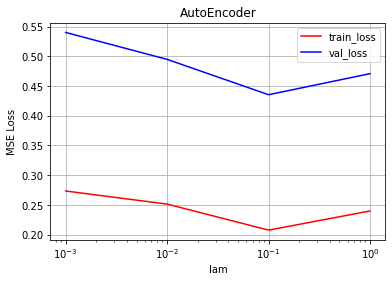


Model Summary:
+----------+----------------+----------+
| Layer    | Output shape   |   Param# |
+==========+================+==========+
| Input    | (None, 753)    |        0 |
+----------+----------------+----------+
| Dense[0] | (None, 256)    |   193024 |
+----------+----------------+----------+
| Dense[1] | (None, 753)    |   193521 |
+----------+----------------+----------+
total trainable parameters: 386545



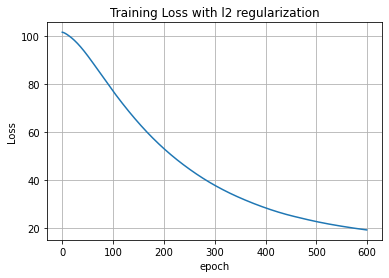


Test result: 

🎁🎁🎁test loss = 0.22


In [14]:
model = AutoEncoder(hidden_units=[256, X.shape[-1]],
                  epoch=600,
                  opt=nn.optims.Adam,
                  lr=1e-3,
                  reg_type="l2",
                  random_state=seed
                  )
lams = [1, 1e-1, 1e-2, 1e-3]
history = {"train_loss": [], "val_loss": []}
best_val_loss = np.inf
best_param = None
scaler = StandardScaler() 

for lr in tqdm(lams):
    avg_val_loss = 0
    avg_train_loss = 0

    for x_train, y_train, x_val, y_val in choose_fold(X, X, cv_num, auto_encoder=True):
        setattr(model, "random_state", seed)
        setattr(model, "lam", lr)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_train)
        avg_train_loss += model.loss_fn(y_train, y_pred).value
        y_pred = model.predict(x_val)
        avg_val_loss += model.loss_fn(y_val, y_pred).value

    history["train_loss"].append(avg_train_loss / cv_num)
    history["val_loss"].append(avg_val_loss / cv_num)

    if history["val_loss"][-1] < best_val_loss:
        best_val_loss = history["val_loss"][-1]
        best_param = lr
        best_loss_hist = model.loss_history

print("\n\t\t==> Auto Encoder <==\n")
print("Training result:")
print("\tbest param: {} = {}\n\tbest validation loss = {:.2f}".format("lam",
                                                                      best_param,
                                                                      best_val_loss))        
plt.plot(lams, history["train_loss"], c="r")
plt.plot(lams, history["val_loss"], c="b")
plt.legend(history.keys())
plt.grid()
plt.title("AutoEncoder")
plt.ylabel("MSE Loss")
plt.xlabel("lam")
plt.xscale("log")
plt.show()

model.model_architecture()
plt.plot(range(model.epoch), best_loss_hist)
plt.grid()
plt.title("Training Loss with l2 regularization")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.show()
    
print("\nTest result: ")
setattr(model, "lam", best_param)
setattr(model, "random_state", seed)
scaler = StandardScaler() 
x_train = scaler.fit_transform(X)
model.fit(x_train, x_train)
x_test_stand = scaler.transform(x_test)
y_pred = model.predict(x_test_stand)
test_loss = model.loss_fn(x_test_stand, y_pred).value
        
print(f"\n🎁🎁🎁test loss = {test_loss:.2f}")

#### The trained auto encoder is extracted.

In [15]:
auto_encoder = model.net._layers[0]

### Neural Network Classifier
Here, we define a class that performs the training and testing procedures of constructing a Neural Network classifier.
- We used _Binary Cross Entropy_ as our cost function since the targets are binary classes.
- The nonlinearity of the hidden layers is ReLU.
- The weights of the hidden layers were initialized by He Normal initializer which is a variant of Xavier initializer but behaves better for ReLU. 
- The bias of the hidden layers were initialized by a small number (0.1).
- We used *l2 regularizer* to perform regularization.
- If the network has more than 1 fully-connected hidden layer then, between each FC hidden layer, we added a Batch-Normalization layer.
- The loss is consisted of a term that is related to the cost function and a term that is related to the *l2 regularization* thus, its value can not explicitly demonstrate the error of the outputs with respect to the targets.
- We tested _Focal Loss_ instead of the _Binary Cross Entropy Loss_ as it is more suitable for imbalance datasets but the performance degraded drastically so, that part got commented out!  

$$\text{Binary Cross Entropy} = y\log{\hat{y}} + (1 - y)\log{(1 - \hat{y})}$$
$$\text{Focal} = (1 - \hat{y})^γ * \text{Binary Cross Enropy}(y, \hat{y})$$

- Activation of the output layer is Sigmoid.
- The weights of the output layer is initialized with Xavier Uniform initializer that keeps the variance among weights high so the gradient flow gets smoother during training.

In [16]:
class NNClassifier:
    def __init__(self,
                 hidden_units: List=[64],
                 epoch=500,
                 lr=0.001,
                 opt: nn.optims.Optimizer=nn.optims.SGD,
                 lam: float=0,
                 reg_type: str=None,
                 random_state=int(time.time())
                ):
        self.hidden_units = hidden_units
        self.epoch = epoch
        self.lr = lr
        self.opt = opt
        self.lam = lam
        self.reg_type = reg_type
        self.seed = random_state
        self.bce_loss = nn.losses.BinaryCrossEntropy() # FocalLoss(gamma=0.2)
        self.model = None
        self.best_weights = None
        self.loss_history = []
        
    def fit(self, x, y):
        self.loss_history = []
        nn.seed(self.seed)
        best_loss = np.inf
        self.best_weights = None
        self.model = None
        n_feat = int(x.shape[-1])

        if self.model is None:
            hidden_units = self.hidden_units
            
            hidden_layers = []
            for i in range(len(hidden_units)):
                hidden_layers.append(nn.layers.Dense(in_features=n_feat,
                                           out_features=hidden_units[i],
                                           activation=nn.acts.ReLU(),
                                           weight_initializer=nn.inits.HeNormal(nn.acts.ReLU()),
                                           bias_initializer=nn.inits.Constant(0.1),
                                           regularizer_type=self.reg_type,
                                           lam=self.lam)
                                    )
                hidden_layers.append(nn.layers.BatchNorm1d(hidden_units[i]))
                n_feat = hidden_units[i]

            if isinstance(hidden_layers[-1], nn.layers.BatchNorm1d):
                hidden_layers.pop(-1) 
            output_layer = nn.layers.Dense(in_features=self.hidden_units[-1],
                                      out_features=1,
                                      activation=nn.acts.Sigmoid(),
                                      weight_initializer=nn.inits.XavierUniform(),
                                      bias_initializer=nn.inits.Constant(0.01),
                                      regularizer_type=self.reg_type,
                                      lam=self.lam
                                      )
            
            
            self.model = nn.Sequential(*hidden_layers, output_layer)
        opt = self.opt(self.model.parameters, lr=self.lr)
            
        for step in range(self.epoch):
            y_pred = self.model(x)
            y_pred = y_pred.squeeze(-1)
            loss = self.bce_loss(y_pred, y)
            self.model.backward(loss)
            opt.apply()

            total_loss = loss.value
            total_loss += sum([0.5 * l.lam * np.sum(l.vars["W"] ** 2) for l in self.model._layers])

            if total_loss < best_loss:
              best_loss = total_loss
              self.best_weights = self.model.parameters


            if step == 0:
                self.loss_history.append(total_loss)
            else:
                self.loss_history.append(0.9 * self.loss_history[-1] + 0.1 * total_loss)
            
    def predict(self, x):
        assert not self.model is None
        self.model.set_weights(self.best_weights)
        pred = self.model(x)
        return np.where(pred > 0.5, 1, 0).squeeze(-1)
    
    def model_architecture(self):
        self.model.summary() 

### Extreme Learning machine
Here, we define a class that performs the training and testing procedures of constructing an Single Layer ELM classifier.
- Targets are transformed to one-hot representation since ELM needs the number of outputs to be equal to number of classes
- The hidden layer has Linear activation as we tested Sigmoid and Tanh as well but the best performance was obtained by Linear activation.
- Weights and biases of the hidden layer were initialized at random uniformly.

In [17]:
class SingleLayerELMClassifier:
    def __init__(self,
                 units: int=64,
                 random_state=int(time.time())
                 ):
        """
        Reference:
        - [Introduction](https://towardsdatascience.com/introduction-to-extreme-learning-machines-c020020ff82b)
        - [code](https://github.com/burnpiro/elm-pure)
        """
        self.units = units
        self.seed = random_state
        self.beta = None
        self.H = None
        self.onehot_fn = OneHotEncoder(sparse=False)
        
    def fit(self, x, y):
        nn.seed(self.seed)
        self.beta = None
        self.H = None
        n_feat = int(x.shape[-1])

        if self.beta is None:
            self.H = nn.layers.Dense(in_features=n_feat,
                                  out_features=self.units,
                                  # activation=nn.acts.Tanh(),
                                  bias_initializer=nn.inits.RandomUniform()
                                  )
        H = self.H.forward(x)
        y = (y + 1).reshape(-1, 1)
        y = self.onehot_fn.fit_transform(y)
        
        self.beta = np.linalg.pinv(H).dot(y)
            
    def predict(self, x):
        assert not self.beta is None
        pred = self.H.forward(x).dot(self.beta)
        return np.argmax(pred, -1)

### Two-Layer ELM
Here, we define the Two-Layer ELM (TELM) classifier.
- We followed all steps of the mentioned paper.
- Targets are transformed to one-hot representation since ELM needs the number of outputs to be equal to number of classes
- The hidden layers has Linear activation
- Weights and biases of the hidden layers were initialized at random uniformly.
- Both layers should have same number of units (neurons).

In [18]:
class TwoHiddenLayerELMClassifier:
    def __init__(self,
                 units: int=64,
                 random_state=int(time.time())
                 ):
        """
        Reference:
        - [Paper](Two-hidden-layer extreme learning machine for regression and classiﬁcation)
        - code: Implemented from scratch
        """
        self.units = units
        self.seed = random_state
        self.beta_new = None
        self.l1 = None
        self.l2 = None
        self.onehot_fn = OneHotEncoder(sparse=False)
        self.eps = 1e-6
        
    def fit(self, x, y):
        nn.seed(self.seed)
        self.beta_new = None
        self.l1 = None
        self.l2 = None
        n_feat = int(x.shape[-1])


        if self.beta_new is None:
            self.l1 = nn.layers.Dense(in_features=n_feat,
                                  out_features=self.units,
                                  bias_initializer=nn.inits.RandomUniform()
                                     )
            self.l2 = nn.layers.Dense(in_features=self.units,
                      out_features=self.units,
                                     )
        y = (y + 1).reshape(-1, 1)
        y = self.onehot_fn.fit_transform(y)
        
        H = self.l1.forward(x)
        beta = np.linalg.pinv(H).dot(y)
        H1 = y.dot(np.linalg.pinv(beta))
        HE = np.concatenate([np.ones(shape=(len(H), 1)), H], axis=-1)
        WHE = np.linalg.pinv(HE).dot(H1)
        H2 = HE.dot(WHE)
        
        self.beta_new = H2.T.dot(y)
        self.l2.vars['W'] = WHE[1:]
        self.l2.vars['b'] = WHE[0]
    def predict(self, x):
        assert not self.beta_new is None
        tmp = self.l1.forward(x)
        pred = self.l2.forward(tmp).dot(self.beta_new)
        return np.argmax(pred, -1)

### Auto Encoder + Neural Network
Here, we define a Neural Network based classifer that is as same as the Neural Network class that we have defined already except that prior to feeding the input to the netowork, we use our previously-trained auto encoder to reduce the dimensionality of the input.
- We don't fine-tune the auto encoder either.

In [19]:
class AutoEncoderNNClassifier(NNClassifier):
    def __init__(self,
                 auto_encoder: nn.layers.Layer,
                 **kwargs
                 ):
        super(AutoEncoderNNClassifier, self).__init__(**kwargs)
        self.ae=auto_encoder
        
    def fit(self, x, y):
        feats = self.ae.forward(x)
        super(AutoEncoderNNClassifier, self).fit(feats, y)
        
    def predict(self, x):
        feats = self.ae.forward(x)
        return super(AutoEncoderNNClassifier, self).predict(feats)

### Models' Definition
To realize integrity and demonstrating how each model is trained based on an identical bottomline, we have described all of our classification methods here to use them in the training loop later.  
The logic behind the this part of the code is that each classifier has a base classifier `base_clf` that all the fixed hyperparameters have been set to it and they won't be changed. Secondly, there is a `param` attribute which is a hyperparameter that we're seeking its optimal value. Third, there is `param_values` that specifes the range that the search of optimal hyperparameter should be done with it. Forth, `selected_param` which is the best parameter selected for that specific classifier. And `metrics` that holds test metrics for each classifier and we will use it to draw our conclusion table.

#### Now let's take a look at each specific classifier's configuration 
- Neural Networks  
1. Four different architecture of Neural Networks tested:  
Single FC layers with 256 to 64 units.  
A two FC layer with 64 and 32 units and a batch normalization layer between them.
2. _Adam_ was selected for optimization.
3. numer of _epochs_ were fixed to 400.
4. _l2 regularizer_ with λ = 1e-3 was used to prevent overfitting.
5. The parameter that we searched to find its optimal value was _learning rate_.
6. The search range was among `[1e-2, 1e-3, 1e-4, 1e-5]`.
- Auto Encoder + Neural Network
1. The auto encoder part was trained before with 256 units.
2. The architecture of the classifier after the auto encoder is a two FC layer with 64 and 32 units and a batch normalization layer between them.
3. _Adam_ was selected for optimization.
4. numer of _epochs_ were fixed to 400.
5. _l2 regularizer_ with λ = 1e-3 was used to prevent overfitting.
6. The parameter that we searched to find its optimal value was _learning rate_.
7. The search range was among `[1e-2, 1e-3, 1e-4, 1e-5]`.
- Single-Layer ELM (SELM)
1. The parameter that we searched for its optimal value was the number of neurons.
2. The search was done on `[4, 8, 16, 32, 64, 128, 256, 512]` considering that ELMs usually needes a large number of neurons to learn
- TWO-Layer ELM (TELM)
1. The parameter that we searched for its optimal value was the number of neurons that must be equal for both layers.
2. The search was done on `[4, 8, 16, 32, 64, 128, 256, 512]`.
- Linear SVM
1. The *One vs One* strategy is used for the optimization since we're dealing with a multi-class classification and *One vs One* is the choice of preference for this kind of problems.
2. The hyperparameter that we're searching for its optimal value is `C`that is proportional to the inverse of regularizer coefficient. Thus, as it increases the regularization effect decreases.
3. Three values of `[1, 10, 100]` was explored.
- RBF SVM
1. The radial-basis function was used as the non-linear kernel function to perform non-linear classification.
2. The *One vs One* strategy is used for the optimization.
3. The hyperparameter that we're searching for its optimal value is `C`.
4. Search range: `[1, 10, 100, 1000, 1e+4, 1e+5]`.
- Decision Tree
1. *entropy* criterion was selected for choosing best features during tree's construction
2. Since we would like to avoid *overfitting* the hyperparameter that is being sought is `max_depth`. Because if we could find relatively small values for this hyperparameter the, the tree would be shallow, simple and more capable of generalization due to the fact that a lot of branches have been pruned.
3. Search range for level of the tree's depth: `[1, 2, ..., 20]`
- Random Forest
1. *entropy* criterion was selected for choosing best features during the forest's tree construction
2. `max_depth` of each tree is taken from the `max_depth` that we obtained from *Decision Tree*. (implemented later in the code.)
3. Since we would like to avoid *overfitting* the hyperparameter that is being sought is `n_estimators` aka `n_tree`. Because if we could find relatively small values for this hyperparameter the, the forest would be sparse, simple and more capable of generalization due to the fact that a lot of tree have been chopped.
4. No bootstraping is allowed and the whole dataset is used for each tree as it was observed that bootstrapping hampers the performance.
5. Search range for the number of trees: `[1, 2, ..., 45]` 
- XGBoost
1. `max_depth` of each tree is taken from the `max_depth` that we obtained from *Decision Tree*. (implemented later in the code.)
2. `n_estimators` of the forest is taken from the `n_estimators` that we obtained from *Random Forest*. (implemented later in the code.)
3. The `booster` type was chosen `gbtree` which means individual learners are tree-based
4. The `tree_method` was chosen to be `hist` as it is similar to the `exact` method that greedily enumerates all candidate splits however, `hist` is faster.
5. Regularizer coefficient chosen to be `1e-3`.
6. loss type was chosen `binary:logistic` aka *Binary Cross Entropy*. (The suitable loos type for binary classification.)
7. `learning_rate` was the hyperparameter that we performed search on since, it is the most influencial hyperparameter for *XGBoost*.
8. Search range for the learning rate: `[1, 5e-1, 1e-2, 5e-3]` 

In [20]:
clfs = {"Neural Net 256": {"base_clf": NNClassifier(hidden_units=[256],
                                                    epoch=400,
                                                    opt=nn.optims.Adam,
                                                    lam=1e-3,
                                                    reg_type="l2",
                                                    random_state=seed
                                                    ),
                           "param": "lr",
                           "param_values": [1e-2, 1e-3, 1e-4, 1e-5],
                           "selected_param": None,
                           "metrics": {"Accuracy": None,
                                       "Macro Precision": None,
                                       "Macro Recall": None,
                                       "Macro F1-Score": None}
                           },
        "Neural Net 128": {"base_clf": NNClassifier(hidden_units=[128],
                                                    epoch=400,
                                                    opt=nn.optims.Adam,
                                                    lam=1e-3,
                                                    reg_type="l2",
                                                    random_state=seed
                                                    ),
                           "param": "lr",
                           "param_values": [1e-2, 1e-3, 1e-4, 1e-5],
                           "selected_param": None,
                           "metrics": {"Accuracy": None,
                                       "Macro Precision": None,
                                       "Macro Recall": None,
                                       "Macro F1-Score": None}
                           },
        "Neural Net 64": {"base_clf": NNClassifier(hidden_units=[64],
                                                   epoch=400,
                                                   opt=nn.optims.Adam,
                                                   lam=1e-3,
                                                   reg_type="l2",
                                                   random_state=seed
                                                   ),
                          "param": "lr",
                          "param_values": [1e-2, 1e-3, 1e-4, 1e-5],
                          "selected_param": None,
                          "metrics": {"Accuracy": None,
                                      "Macro Precision": None,
                                      "Macro Recall": None,
                                      "Macro F1-Score": None}
                          },
        "Neural Net 64_32": {"base_clf": NNClassifier(hidden_units=[64, 32],
                                                      epoch=400,
                                                      opt=nn.optims.Adam,
                                                      lam=1e-3,
                                                      reg_type="l2",
                                                      random_state=seed
                                                      ),
                             "param": "lr",
                             "param_values": [1e-2, 1e-3, 1e-4, 1e-5],
                             "selected_param": None,
                             "metrics": {"Accuracy": None,
                                         "Macro Precision": None,
                                         "Macro Recall": None,
                                         "Macro F1-Score": None}
                             },
        "Auto Encoder Neural Net": {"base_clf": AutoEncoderNNClassifier(auto_encoder=auto_encoder,
                                                                        hidden_units=[64, 32],
                                                                        epoch=400,
                                                                        opt=nn.optims.Adam,
                                                                        lam=1e-3,
                                                                        reg_type="l2",
                                                                        random_state=seed
                                                                        ),
                                    "param": "lr",
                                    "param_values": [1e-2, 1e-3, 1e-4, 1e-5],
                                    "selected_param": None,
                                    "metrics": {"Accuracy": None,
                                                "Macro Precision": None,
                                                "Macro Recall": None,
                                                "Macro F1-Score": None}
                                    },
        "SELM": {"base_clf": SingleLayerELMClassifier(random_state=seed
                                                      ),
                 "param": "units",
                 "param_values": 2 ** np.linspace(2, 9, num=8).astype(int),
                 "selected_param": None,
                 "metrics": {"Accuracy": None,
                             "Macro Precision": None,
                             "Macro Recall": None,
                             "Macro F1-Score": None}
                 },
        "TELM": {"base_clf": TwoHiddenLayerELMClassifier(random_state=seed
                                                         ),
                 "param": "units",
                 "param_values": 2 ** np.linspace(2, 9, num=8).astype(int),
                 "selected_param": None,
                 "metrics": {"Accuracy": None,
                             "Macro Precision": None,
                             "Macro Recall": None,
                             "Macro F1-Score": None}
                 },
        "Linear SVM": {"base_clf": SVC(decision_function_shape="ovo",
                                       random_state=seed),
                       "param": "C",
                       "param_values": [1, 10, 100],
                       "selected_param": None,
                       "metrics": {"Accuracy": None,
                                   "Macro Precision": None,
                                   "Macro Recall": None,
                                   "Macro F1-Score": None}
                       },
        "RBF-SVM": {"base_clf": SVC(kernel="rbf",
                                    decision_function_shape="ovo",
                                    random_state=seed),
                    "param": "C",
                    "param_values": [1, 10, 100, 1000, 1e+4, 1e+5],
                    "selected_param": None,
                    "metrics": {"Accuracy": None,
                                "Macro Precision": None,
                                "Macro Recall": None,
                                "Macro F1-Score": None}
                    },
        "Decision Tree": {"base_clf": DecisionTreeClassifier(criterion="entropy", random_state=seed),
                          "param": "max_depth",
                          "param_values": np.arange(1, 21),
                          "selected_param": None,
                          "metrics": {"Accuracy": None,
                                      "Macro Precision": None,
                                      "Macro Recall": None,
                                      "Macro F1-Score": None}
                          },
        "Random Forest": {"base_clf": RandomForestClassifier(criterion="entropy",
                                                             random_state=seed,
                                                             bootstrap=False),
                          "param": "n_estimators",
                          "param_values": np.arange(1, 46),
                          "selected_param": None,
                          "metrics": {"Accuracy": None,
                                      "Macro Precision": None,
                                      "Macro Recall": None,
                                      "Macro F1-Score": None}
                          },
        "XGBoost": {"base_clf": XGBClassifier(booster="gbtree",
                                              tree_method="hist",
                                              reg_lambda=1e-3,
                                              random_state=seed,
                                              objective='binary:logistic',
                                              use_label_encoder=True,
                                              verbosity=0),
                    "param": "learning_rate",
                    "param_values": [1, 5e-1, 1e-2, 5e-3],
                    "selected_param": None,
                    "metrics": {"Accuracy": None,
                                "Macro Precision": None,
                                "Macro Recall": None,
                                "Macro F1-Score": None}
                    }
        }


### Main Loop
#### Logic:
For every classifier we search over its range of values for the hyperparameter it needs to find. We perform *5-fold cross validation* and the best hyperparameter is the one that its corrrespondig average model during *5-fold cross validation* achieves the highest *validation f1_score*. Then, we report the important training and validation metrics.  
Then, performance metrics on the test data that we put aside in the first place is computed and reported and based on that, the best model found yet is selected. At last, `max_depth` and `n_estimators` of *Decision Tree* and *Random Forest* algorithms are used for further related algorithms such as *XGBoost*.

__It's important to note that the Standardization was fitted on the training data and during test phase we used those values as well.__

Neural Net 256: 100%|██████████| 4/4 [04:50<00:00, 72.70s/it]



		==> Neural Net 256 <==
Training result:
	best param: lr = 0.001
	best validation f1-score = 0.83


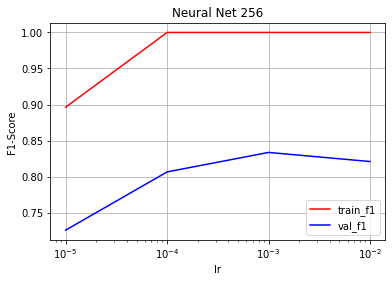


Model Summary:
+----------+----------------+----------+
| Layer    | Output shape   |   Param# |
+==========+================+==========+
| Input    | (None, 753)    |        0 |
+----------+----------------+----------+
| Dense[0] | (None, 256)    |   193024 |
+----------+----------------+----------+
| Dense[1] | (None, 1)      |      257 |
+----------+----------------+----------+
total trainable parameters: 193281



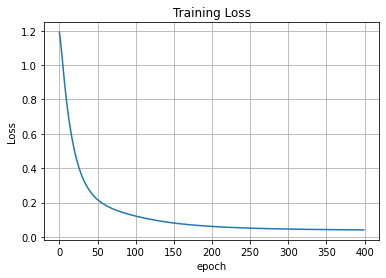


Test result: 


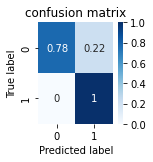

              precision    recall  f1-score   support

         0.0       1.00      0.78      0.88        18
         1.0       0.93      1.00      0.97        57

    accuracy                           0.95        75
   macro avg       0.97      0.89      0.92        75
weighted avg       0.95      0.95      0.94        75



Neural Net 128: 100%|██████████| 4/4 [02:43<00:00, 40.86s/it]



		==> Neural Net 128 <==
Training result:
	best param: lr = 0.001
	best validation f1-score = 0.83


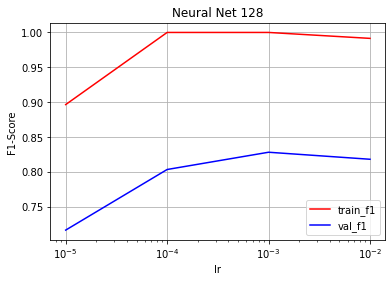


Model Summary:
+----------+----------------+----------+
| Layer    | Output shape   |   Param# |
+==========+================+==========+
| Input    | (None, 753)    |        0 |
+----------+----------------+----------+
| Dense[0] | (None, 128)    |    96512 |
+----------+----------------+----------+
| Dense[1] | (None, 1)      |      129 |
+----------+----------------+----------+
total trainable parameters: 96641



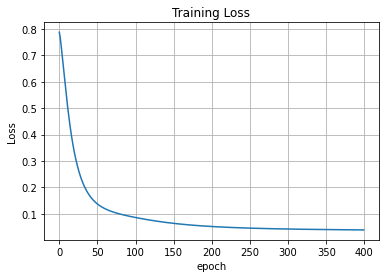


Test result: 


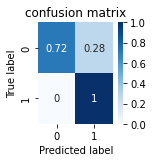

              precision    recall  f1-score   support

         0.0       1.00      0.72      0.84        18
         1.0       0.92      1.00      0.96        57

    accuracy                           0.93        75
   macro avg       0.96      0.86      0.90        75
weighted avg       0.94      0.93      0.93        75



Neural Net 64: 100%|██████████| 4/4 [01:38<00:00, 24.64s/it]



		==> Neural Net 64 <==
Training result:
	best param: lr = 0.001
	best validation f1-score = 0.83


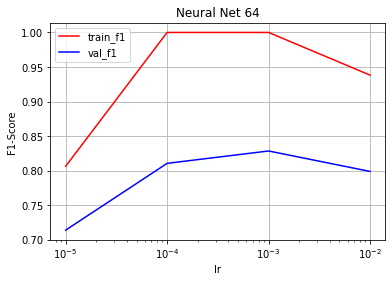


Model Summary:
+----------+----------------+----------+
| Layer    | Output shape   |   Param# |
+==========+================+==========+
| Input    | (None, 753)    |        0 |
+----------+----------------+----------+
| Dense[0] | (None, 64)     |    48256 |
+----------+----------------+----------+
| Dense[1] | (None, 1)      |       65 |
+----------+----------------+----------+
total trainable parameters: 48321



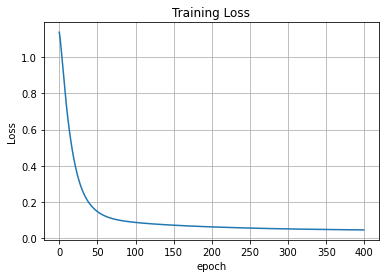


Test result: 


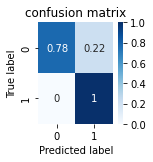

              precision    recall  f1-score   support

         0.0       1.00      0.78      0.88        18
         1.0       0.93      1.00      0.97        57

    accuracy                           0.95        75
   macro avg       0.97      0.89      0.92        75
weighted avg       0.95      0.95      0.94        75



Neural Net 64_32: 100%|██████████| 4/4 [02:08<00:00, 32.12s/it]



		==> Neural Net 64_32 <==
Training result:
	best param: lr = 0.001
	best validation f1-score = 0.82


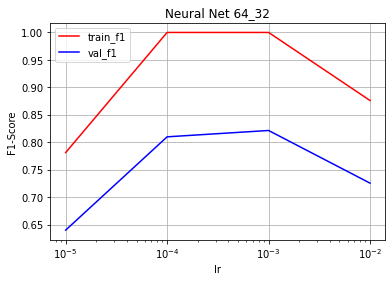


Model Summary:
+----------------+----------------+----------+
| Layer          | Output shape   |   Param# |
+================+================+==========+
| Input          | (None, 753)    |        0 |
+----------------+----------------+----------+
| Dense[0]       | (None, 64)     |    48256 |
+----------------+----------------+----------+
| BatchNorm1d[1] | (None, 64)     |      128 |
+----------------+----------------+----------+
| Dense[2]       | (None, 32)     |     2080 |
+----------------+----------------+----------+
| Dense[3]       | (None, 1)      |       33 |
+----------------+----------------+----------+
total trainable parameters: 50497



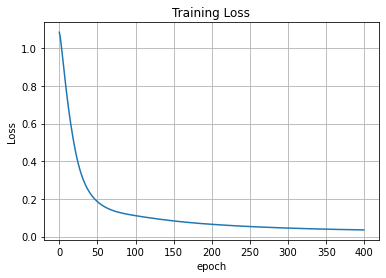


Test result: 


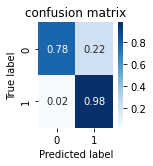

              precision    recall  f1-score   support

         0.0       0.93      0.78      0.85        18
         1.0       0.93      0.98      0.96        57

    accuracy                           0.93        75
   macro avg       0.93      0.88      0.90        75
weighted avg       0.93      0.93      0.93        75



Auto Encoder Neural Net: 100%|██████████| 4/4 [01:09<00:00, 17.27s/it]



		==> Auto Encoder Neural Net <==
Training result:
	best param: lr = 0.001
	best validation f1-score = 0.79


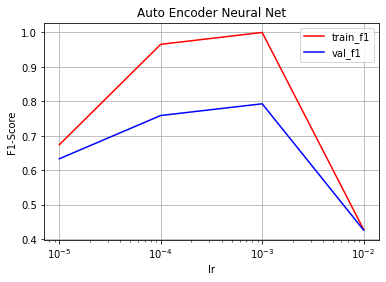


Model Summary:
+----------------+----------------+----------+
| Layer          | Output shape   |   Param# |
+================+================+==========+
| Input          | (None, 256)    |        0 |
+----------------+----------------+----------+
| Dense[0]       | (None, 64)     |    16448 |
+----------------+----------------+----------+
| BatchNorm1d[1] | (None, 64)     |      128 |
+----------------+----------------+----------+
| Dense[2]       | (None, 32)     |     2080 |
+----------------+----------------+----------+
| Dense[3]       | (None, 1)      |       33 |
+----------------+----------------+----------+
total trainable parameters: 18689



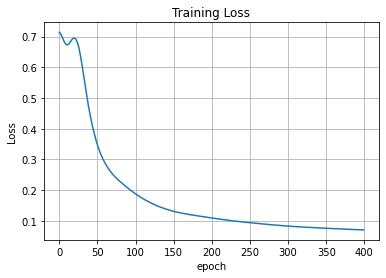


Test result: 


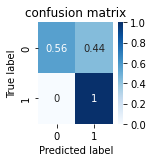

              precision    recall  f1-score   support

         0.0       1.00      0.56      0.71        18
         1.0       0.88      1.00      0.93        57

    accuracy                           0.89        75
   macro avg       0.94      0.78      0.82        75
weighted avg       0.91      0.89      0.88        75



SELM: 100%|██████████| 8/8 [00:02<00:00,  3.52it/s]



		==> SELM <==
Training result:
	best param: units = 256
	best validation f1-score = 0.71


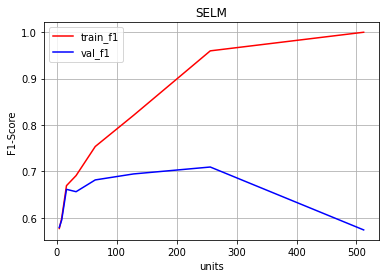


Test result: 


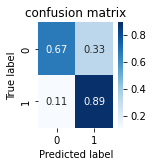

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67        18
         1.0       0.89      0.89      0.89        57

    accuracy                           0.84        75
   macro avg       0.78      0.78      0.78        75
weighted avg       0.84      0.84      0.84        75



TELM: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]



		==> TELM <==
Training result:
	best param: units = 256
	best validation f1-score = 0.74


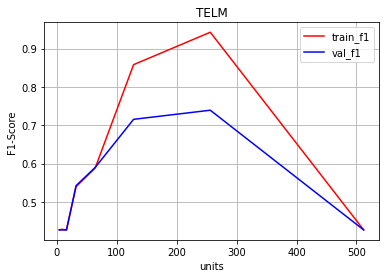


Test result: 


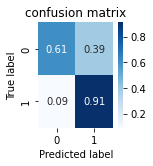

              precision    recall  f1-score   support

         0.0       0.69      0.61      0.65        18
         1.0       0.88      0.91      0.90        57

    accuracy                           0.84        75
   macro avg       0.78      0.76      0.77        75
weighted avg       0.83      0.84      0.84        75



Linear SVM: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]



		==> Linear SVM <==
Training result:
	best param: C = 10
	best validation f1-score = 0.82


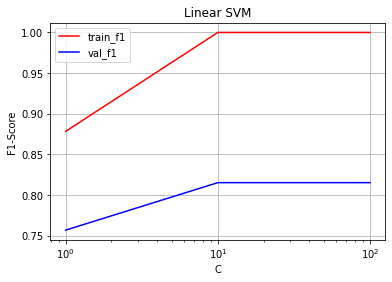


Test result: 


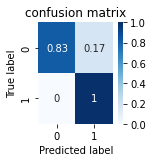

              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91        18
         1.0       0.95      1.00      0.97        57

    accuracy                           0.96        75
   macro avg       0.97      0.92      0.94        75
weighted avg       0.96      0.96      0.96        75



RBF-SVM: 100%|██████████| 6/6 [00:07<00:00,  1.19s/it]



		==> RBF-SVM <==
Training result:
	best param: C = 10
	best validation f1-score = 0.82


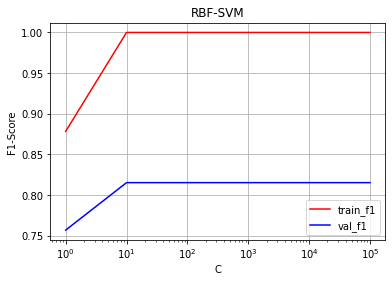


Test result: 


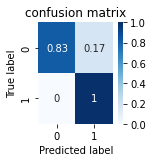

              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91        18
         1.0       0.95      1.00      0.97        57

    accuracy                           0.96        75
   macro avg       0.97      0.92      0.94        75
weighted avg       0.96      0.96      0.96        75



Decision Tree: 100%|██████████| 20/20 [00:36<00:00,  1.82s/it]



		==> Decision Tree <==
Training result:
	best param: max_depth = 7
	best validation f1-score = 0.75


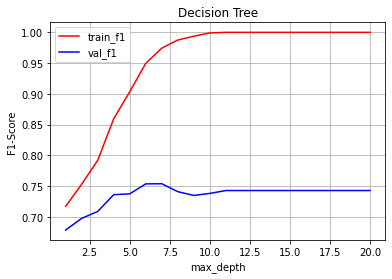


Test result: 


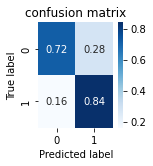

              precision    recall  f1-score   support

         0.0       0.59      0.72      0.65        18
         1.0       0.91      0.84      0.87        57

    accuracy                           0.81        75
   macro avg       0.75      0.78      0.76        75
weighted avg       0.83      0.81      0.82        75



Random Forest: 100%|██████████| 45/45 [01:34<00:00,  2.11s/it]


		==> Random Forest <==
Training result:
	best param: n_estimators = 11
	best validation f1-score = 0.82


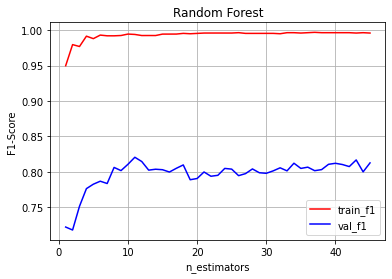


Test result: 


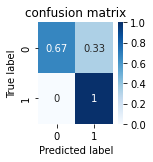

              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80        18
         1.0       0.90      1.00      0.95        57

    accuracy                           0.92        75
   macro avg       0.95      0.83      0.88        75
weighted avg       0.93      0.92      0.91        75



XGBoost: 100%|██████████| 4/4 [00:38<00:00,  9.59s/it]



		==> XGBoost <==
Training result:
	best param: learning_rate = 0.5
	best validation f1-score = 0.81


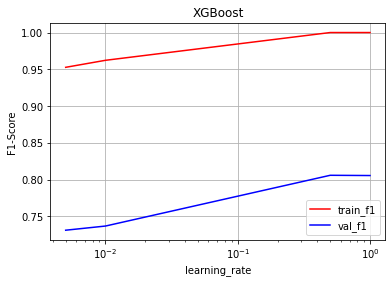


Test result: 


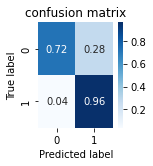

              precision    recall  f1-score   support

         0.0       0.87      0.72      0.79        18
         1.0       0.92      0.96      0.94        57

    accuracy                           0.91        75
   macro avg       0.89      0.84      0.86        75
weighted avg       0.90      0.91      0.90        75


🎁🎁🎁best_model is: Linear SVM with test f1-score = 0.94.


In [21]:
best_test_f1 = -np.inf
best_model = {}

for clf_name, config in clfs.items():
    history = {"train_f1": [], "val_f1": []}
    best_val_f1 = 0
    best_param = None

    for p in tqdm(config["param_values"], total=len(config["param_values"]), desc=clf_name):
        avg_val_f1 = 0
        avg_train_f1 = 0

        for x_train, y_train, x_val, y_val in choose_fold(X, Y, cv_num):
            clf = config["base_clf"]
            setattr(clf, "random_state", seed)
            setattr(clf, config["param"], p)
            clf.fit(x_train, y_train)
            y_pred = clf.predict(x_train)
            avg_train_f1 += f1_score(y_train, y_pred, average='macro')
            y_pred = clf.predict(x_val)
            avg_val_f1 += f1_score(y_val, y_pred, average='macro')

        history["train_f1"].append(avg_train_f1 / cv_num)
        history["val_f1"].append(avg_val_f1 / cv_num)

        if history["val_f1"][-1] > best_val_f1:
            best_val_f1 = history["val_f1"][-1]
            best_param = p
            config["selected_param"] = best_param
            if "Neural Net" in clf_name:
                best_loss_hist = clf.loss_history

    print(f"\n\t\t==> {clf_name} <==")
    print("Training result:")
    print("\tbest param: {} = {}\n\tbest validation f1-score = {:.2f}".format(config["param"],
                                                                               best_param,
                                                                               best_val_f1))        
    plt.plot(config["param_values"], history["train_f1"], c="r")
    plt.plot(config["param_values"], history["val_f1"], c="b")
    plt.legend(history.keys())
    plt.grid()
    plt.title(clf_name)
    plt.ylabel("F1-Score")
    plt.xlabel(config["param"])
    if any(name in clf_name for name in ["SVM", "XGBoost", "Neural Net"]):
        plt.xscale("log")
    plt.show()
    
    if "Neural Net" in clf_name:
        clf.model_architecture()
        plt.plot()
        plt.plot(range(clf.epoch), best_loss_hist)
        plt.grid()
        plt.title("Training Loss")
        plt.ylabel("Loss")
        plt.xlabel("epoch")
        plt.show()
        
    print("\nTest result: ")
    setattr(clf, config["param"], best_param)
    scaler = StandardScaler()
    total_x_train = scaler.fit_transform(X)
    clf.fit(total_x_train, Y)
    x_test_stand = scaler.transform(x_test)
    y_pred = clf.predict(x_test_stand)
    test_f1 = f1_score(y_test, y_pred, average='macro')
    if test_f1 > best_test_f1:
        best_test_f1 = test_f1
        best_model["name"] = clf_name
        best_model["clf"] = clf
    con_mat = confusion_matrix(y_test, y_pred)
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_df = pd.DataFrame(con_mat_norm, index=[i for i in range(n_class)], columns=[i for i in range(n_class)])
    figure = plt.figure(figsize=(n_class, n_class))
    sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('confusion matrix')
    plt.show()
    report = classification_report(y_test, y_pred)
    print(report)
    report = classification_report(y_test, y_pred, output_dict=True)
    config["metrics"]["Accuracy"] = report["accuracy"]
    config["metrics"]["Macro Precision"] = report["macro avg"]["precision"]
    config["metrics"]["Macro Recall"] = report["macro avg"]["recall"]
    config["metrics"]["Macro Precision"] = report["macro avg"]["precision"]
    config["metrics"]["Macro F1-Score"] = report["macro avg"]["f1-score"]



    if clf_name == "Decision Tree":
        setattr(clfs["Random Forest"]["base_clf"], "max_depth", best_param)
        setattr(clfs["XGBoost"]["base_clf"], "max_depth", best_param)

    if clf_name == "Random Forest":
        setattr(clfs["XGBoost"]["base_clf"], "n_estimators", best_param)
        
print(f"\n🎁🎁🎁best_model is: {best_model['name']} with test f1-score = {best_test_f1:.2f}.")

### Best model
Since the dataset is __imbalanced__, the *f1-score* metric on the test set can be a good measure for choosing the best model therefore, the best models are RBF and Linear SVMs wth f1-score = 94%

### Metrics and confusion matrix for the best model

test f1-score = 0.94


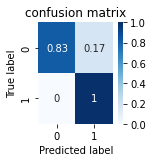

              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91        18
         1.0       0.95      1.00      0.97        57

    accuracy                           0.96        75
   macro avg       0.97      0.92      0.94        75
weighted avg       0.96      0.96      0.96        75



In [22]:
clf = best_model["clf"]
scaler = StandardScaler()
total_x_train = scaler.fit_transform(X)
clf.fit(total_x_train, Y)
x_test_stand = scaler.transform(x_test)
y_pred = clf.predict(x_test_stand)
test_f1 = f1_score(y_test, y_pred, average='macro')
print(f"test f1-score = {test_f1:.2f}")
con_mat = confusion_matrix(y_test, y_pred)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm, index=[i for i in range(n_class)], columns=[i for i in range(n_class)])
figure = plt.figure(figsize=(n_class, n_class))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('confusion matrix')
plt.show()
report = classification_report(y_test, y_pred)
print(report)

### Table of resutls
We use _tabulate_ package to draw the table of our metrics.

In [23]:
from tabulate import tabulate

headers = ["Method", "Value of Parameter", "Accuracy", "Precision", "Recall", "F1-Score"]
data = []
for clf_name, config in clfs.items():
  data.append((clf_name, config["param"] + " = " + str(config["selected_param"]), *[f"{v:.2f}" for v in config["metrics"].values()]))

print(tabulate(data, headers=headers, tablefmt="pipe"))

| Method                  | Value of Parameter   |   Accuracy |   Precision |   Recall |   F1-Score |
|:------------------------|:---------------------|-----------:|------------:|---------:|-----------:|
| Neural Net 256          | lr = 0.001           |       0.95 |        0.97 |     0.89 |       0.92 |
| Neural Net 128          | lr = 0.001           |       0.93 |        0.96 |     0.86 |       0.9  |
| Neural Net 64           | lr = 0.001           |       0.95 |        0.97 |     0.89 |       0.92 |
| Neural Net 64_32        | lr = 0.001           |       0.93 |        0.93 |     0.88 |       0.9  |
| Auto Encoder Neural Net | lr = 0.001           |       0.89 |        0.94 |     0.78 |       0.82 |
| SELM                    | units = 256          |       0.84 |        0.78 |     0.78 |       0.78 |
| TELM                    | units = 256          |       0.84 |        0.78 |     0.76 |       0.77 |
| Linear SVM              | C = 10               |       0.96 |        0.97 |     

| Method                  | Value of Parameter   |   Accuracy |   Precision |   Recall |   F1-Score |
|:------------------------|:---------------------|-----------:|------------:|---------:|-----------:|
| Neural Net 256          | lr = 0.001           |       0.95 |        0.97 |     0.89 |       0.92 |
| Neural Net 128          | lr = 0.001           |       0.93 |        0.96 |     0.86 |       0.9  |
| Neural Net 64           | lr = 0.001           |       0.95 |        0.97 |     0.89 |       0.92 |
| Neural Net 64_32        | lr = 0.001           |       0.93 |        0.93 |     0.88 |       0.9  |
| Auto Encoder Neural Net | lr = 0.001           |       0.89 |        0.94 |     0.78 |       0.82 |
| SELM                    | units = 256          |       0.84 |        0.78 |     0.78 |       0.78 |
| TELM                    | units = 256          |       0.84 |        0.78 |     0.76 |       0.77 |
| Linear SVM              | C = 10               |       0.96 |        0.97 |     0.92 |       0.94 |
| RBF-SVM                 | C = 10               |       0.96 |        0.97 |     0.92 |       0.94 |
| Decision Tree           | max_depth = 7        |       0.81 |        0.75 |     0.78 |       0.76 |
| Random Forest           | n_estimators = 11    |       0.92 |        0.95 |     0.83 |       0.88 |
| XGBoost                 | learning_rate = 0.5  |       0.91 |        0.89 |     0.84 |       0.86 |

### Results of the paper (Table 5 in the paper)
|   Method   | Accuracy   |  F1-Score  |    
| :--------: | ---------: |:----------:|
| MLP        | 0.93       | 0.80       |
| Random Forest| 0.79     | 0.78       |
| Linear SVM   | 0.81     | 0.80       |
| RBF SVM      | 0.86     | 0.84       |

- By comparing our results with the paper, we see that our best model Linear (RBF) SVM outperforms the best model of the paper (RBF SVM) with a f1-score of 0.94 compared to 0.84.
- Further more, by model-to-model comparision, still our models (that may not be the best one) outperforms their counterpart in the paper:
1. MLP classifier of the paper has a f1-score of 0.80 while our f1-scores for Neural Network classifiers is at least 0.90.
2- The paper managed to obtain a f1-score for Random Forest with a value euqals to 0.78 while we could obtain 0.88
3. For Linear SVM  we could achieve 0.94 compared to 0.80 of the paper.
4. For RBF SVM  we could achieve 0.94 compared to 0.84 of the paper.
